In [6]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Clustering Based on Musical Data

The main goal of this project is to show how we can use strictly audio analysis data to inform song recommendation from the standpoint of a music streaming service.

I used the Spotify API to gather audio analysis data (timbre vectors) and some extra data points to be used strictly for interpretation. Looking at the actual data used for clustering is going to be practically meaningless to any human looking at it.

A quick primer into what "timbre" is in this context:
Essentially the frequency spectrum is divided up into sections. We look at the sections both individually and how they relate to each other.

For an in-depth view into how the data was generated check out the cov_gen notebook.

In [7]:
import warnings
import math

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interact_manual
from ipywidgets import FloatSlider

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
def get_keyword_counts(data):
    micro_genre_count = {}
    word_count = {}
    for x in data["genres"]:
        m_genres = x.split(", ")
        for m in m_genres:
            if m not in micro_genre_count:
                micro_genre_count[m] = 1
            else:
                micro_genre_count[m] += 1
            words = m.split(" ")
            for word in words:
                if word not in word_count:
                    word_count[word] = 1
                else:
                    word_count[word] += 1
    try:
        del micro_genre_count[""]
        del word_count[""]
    except:
        pass
    return micro_genre_count, word_count

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
df = pd.read_csv("data/tracks.csv", index_col=0)
pitch_df = pd.read_csv("data/pitch_covariance.csv", index_col=0)
timbre_df = pd.read_csv("data/timbre_covariance.csv", index_col=0)
art_df = pd.read_csv("data/artist_info.csv", index_col=0)
# Many artists with few followers don't have a genre as defined by Spotify
df["genres"] = df["genres"].fillna("not listed")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# This is the data we will be learning on. As you can see, it's quite meaningless
X = timbre_df.drop("id", 1)
# these columns cause some multicollinearity issues.
# checked by using VIF
drop_cols = ["t2-t2", "t3-t3", "t5-t5", "t7-t7", "t9-t9", "t10-t10"]

X = X.drop(drop_cols, 1)
timbre_df.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t10-t9,t11-t9,t0-t10,t1-t10,t10-t10,t0-t11,t1-t11,t10-t11,t11-t11,id
0,46.858569,44.411633,-30.611277,16.679608,24.081611,19.701484,-11.396656,2.506514,-4.164536,7.458277,...,23.006361,94.763566,22.384988,25.194126,1033.044512,-11.459746,-13.901388,-130.183017,287.766839,4Oun2ylbjFKMPTiaSbbCih
1,47.159141,-4.288257,16.865750,1.418398,31.826047,-12.211672,8.417109,-1.868587,-14.938674,-6.903131,...,-14.494244,6.548969,-5.519381,-66.234447,487.482081,-4.341169,-104.505943,-63.314290,209.365441,2SAqBLGA283SUiwJ3xOUVI
2,49.515635,16.938579,-20.712831,-17.707178,26.324125,-15.340620,-0.283205,6.923570,-9.580792,-2.385083,...,17.080190,28.006680,14.855904,80.285308,595.003409,-9.714251,2.217014,-99.822412,181.863172,3H7ihDc1dqLriiWXwsc2po
3,52.502006,40.068994,0.873336,-11.979764,41.415433,-32.069600,0.215288,-0.099545,-12.413600,1.999788,...,52.498463,3.833241,-2.064249,-20.525046,309.388360,-9.336740,75.105173,-19.921382,143.134342,6UelLqGlWMcVH1E5c4H7lY
4,47.822759,19.388920,-13.728099,-0.509172,31.229071,-11.967344,-5.113186,-2.071599,-15.770531,2.152821,...,16.023638,44.897820,-11.715826,-96.440490,487.376608,-23.759403,-31.718711,-24.650577,281.271995,7ytR5pFWmSjzHJIeQkgog4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
scaler = StandardScaler()
std_X = scaler.fit_transform(X)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# putting together hover information for plotly data later
# none of this is being used for umap/clustering

desc_cols = [
    "artist",
    "title",
    "popularity",
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "genres",
]

px_num = df[desc_cols].select_dtypes("number")
px_cat = df[desc_cols].select_dtypes("O")

minmax_scaler = MinMaxScaler()
scaled_num = pd.DataFrame(minmax_scaler.fit_transform(px_num), columns=px_num.columns)
px_df = pd.concat([scaled_num, px_cat], 1)
px_df = px_df.round(1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Possibly the biggest challenge working with data like this is interpretation of clusters. We're taking art and trying to boil it down to a set of numbers. Due to the nature of the project, I think it is very important to limit the process to something that is clear in only two dimensions.

To show how noisy this can be, I'll do some very simple clustering and view the result using PCA

In [13]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(std_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(std_X), columns=["c0", "c1"])

np.sum(pca.explained_variance_ratio_)

0.21321683458253435

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

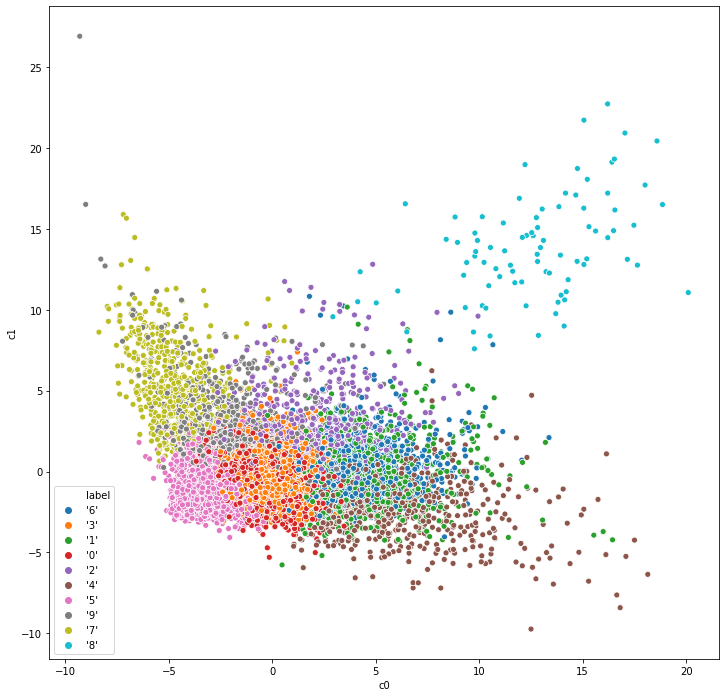

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
pca_df["label"] = kmeans.labels_
pca_df["label"] = "'" + pca_df["label"].astype(str) + "'"
plt.figure(figsize=(12, 12))
sns.scatterplot("c0", "c1", hue="label", data=pca_df)

The clusters are incredibly mixed up and nearly impossible to trace. It's also important to note that PCA only captures 21% of the variance in 2 dimensions

In [ ]:
#high n_neighbors to try to preserve the global structure some
# very low min dist to let the most similar songs to become very dense
umap = UMAP(
    n_components=2, n_neighbors=40, min_dist=0.001, metric="cosine", random_state=42,
)
umap_df = pd.DataFrame(umap.fit_transform(std_X), columns=["c0", "c1"])


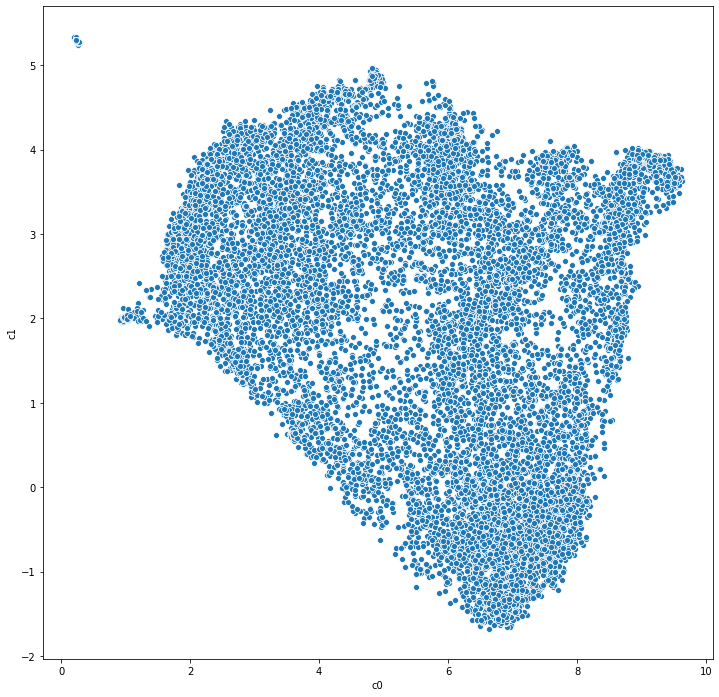

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
plt.figure(figsize=(12, 12))
sns.scatterplot("c0", "c1", data=umap_df)

We still have a lot of noise but some clusters are starting to become more apparent. There's clearly something going on in the top left there worth exploring. Next, we'll use DBSCAN to remove the noise and reveal the areas that are the most densely packed

In [25]:
# adding more to the plotting df
px_df["x1"] = umap_df["c0"]
px_df["x2"] = umap_df["c1"]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
clst = DBSCAN(eps=0.127, min_samples=30)
clst.fit(umap_df[["c0", "c1"]])

DBSCAN(algorithm='auto', eps=0.127, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=30, n_jobs=None, p=None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
px_df["clst_label"] = clst.labels_
px_df["clst_label"].nunique()

29

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Remove DBSCAN's outlier cluster
plot_df = px_df[px_df["clst_label"] != -1].copy()

# Make cluster label a string so plotly colors like categorical rather than continuous
plot_df["clst_label"] = "'" + plot_df["clst_label"].astype(str) + "'"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

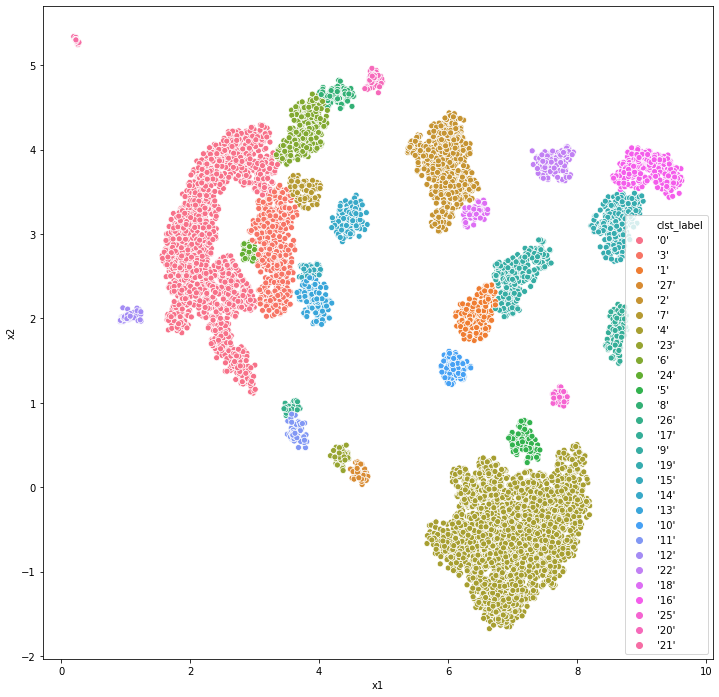

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
plt.figure(figsize=(12, 12))
sns.scatterplot("x1", "x2", hue="clst_label", data=plot_df)

Now we begin to really see where the plot is most dense. Let's switch over to plotly to learn more about the data.

In [30]:
# make the graph consistent
x_range = [math.floor(plot_df["x1"].min()), math.ceil(plot_df["x1"].max())]
y_range = [math.floor(plot_df["x2"].min()), math.ceil(plot_df["x2"].max())]

descriptors = px_num.columns

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using the information Spotify gives us, we can start to see where these songs intersect and diverge. Feel free to pick a new columns to filter by. I recommend **energy, acousticness, and danceability**

In [40]:
@interact(color_by=descriptors)
def song_plot(color_by):
    int_plot_df = plot_df.copy()
    fig = px.scatter(
        data_frame=int_plot_df,
        x="x1",
        y="x2",
        color=color_by,
        hover_data=desc_cols + ["clst_label"],
        range_x=x_range,
        range_y=y_range,
        opacity=0.3,
    )

    fig.show()

interactive(children=(Dropdown(description='color_by', options=('popularity', 'danceability', 'energy', 'loudn…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mousing through, you may have noticed that some of the clusters have specific genres that keep popping up

In [44]:
micro_genre_count, word_count = get_keyword_counts(df)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
m_genre_series = pd.Series(micro_genre_count)
word_count_series = pd.Series(word_count)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
whole_df_m_genre_rep = m_genre_series / df.shape[0]
whole_df_w_count_rep = word_count_series / df.shape[0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
clust_genre_dict = {}
clust_word_dict = {}
# this counts up every time a genre or a word shows up in a single cluster
for cl in px_df["clst_label"].unique():
    cluster_sub_df = px_df[px_df["clst_label"] == cl]
    micro_genre_count, word_count = get_keyword_counts(cluster_sub_df)

    m_genre_series = pd.Series(micro_genre_count)
    word_series = pd.Series(word_count)

    m_genre_rep = m_genre_series / cluster_sub_df.shape[0]
    w_count_rep = word_series / cluster_sub_df.shape[0]

    clust_genre_dict["cluster_" + str(cl)] = m_genre_rep
    clust_word_dict["cluster_" + str(cl)] = w_count_rep

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
cluster_genre_df = pd.DataFrame(clust_genre_dict)
cluster_keyword_df = pd.DataFrame(clust_word_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
all_top_7 = []
all_top_12 = []
for col in cluster_genre_df.columns:
    # find the 7 genres that occur most frequently in the cluster
    top_7_g = cluster_genre_df[col].sort_values(ascending=False)[0:7]
    # reference the index to find the values for the whole data frame
    top_7_comp = whole_df_m_genre_rep[top_7_g.index]
    print("Micro Genre Comparison")
    display(
        pd.DataFrame(
            [top_7_g, top_7_comp], index=[col, "df"]
        ).T.style.background_gradient(axis=1)
    )
    # store to help create another plotting df
    all_top_7 += list(top_7_g.index)
    top_12_w = cluster_keyword_df[col].sort_values(ascending=False)[0:12]
    top_12_comp = whole_df_w_count_rep[top_12_w.index]
    print("Keyword Comparison")
    display(
        pd.DataFrame(
            [top_12_w, top_12_comp], index=[col, "df"]
        ).T.style.background_gradient(axis=1)
    )
    all_top_12 += list(top_12_w.index)
    
#Here you can see the frequency a genre or word shows up in
# a single cluster vs the frequency it shows up in the whole dataframe
# scroll further for a more friendly visual representation of this.

Micro Genre Comparison


,cluster_0,df
rap,0.224352,0.045903
pop,0.176437,0.104659
pop rap,0.173619,0.043531
hip hop,0.143179,0.034121
trap,0.135851,0.024176
dance pop,0.121195,0.076658
melodic rap,0.100338,0.016755


Keyword Comparison


,cluster_0,df
pop,0.988726,0.748068
rap,0.860767,0.195088
hip,0.819617,0.191646
hop,0.780158,0.177645
trap,0.304397,0.061816
r&b,0.272830,0.089205
dance,0.136415,0.120802
indie,0.120068,0.181317
dancehall,0.110485,0.032438
reggae,0.108230,0.055160


Micro Genre Comparison


,cluster_3,df
latin,0.274766,0.032974
reggaeton,0.246729,0.016296
pop,0.177570,0.104659
dance pop,0.160748,0.076658
tropical,0.155140,0.018208
latin pop,0.127103,0.022263
reggaeton flow,0.112150,0.006120


Keyword Comparison


,cluster_3,df
pop,1.282243,0.748068
latin,0.564486,0.112922
reggaeton,0.467290,0.030755
hip,0.299065,0.191646
hop,0.278505,0.177645
rap,0.211215,0.195088
tropical,0.207477,0.043761
dance,0.196262,0.120802
trap,0.173832,0.061816
reggae,0.143925,0.055160


Micro Genre Comparison


,cluster_-1,df
pop,0.118305,0.104659
dance pop,0.087938,0.076658
not listed,0.075917,0.075128
rock,0.066006,0.075281
soul,0.054407,0.036340
funk,0.050401,0.034504
quiet storm,0.040700,0.027848


Keyword Comparison


,cluster_-1,df
pop,0.785955,0.748068
rock,0.559047,0.592304
indie,0.194854,0.181317
jazz,0.189582,0.154005
soul,0.174610,0.131283
country,0.140025,0.117359
modern,0.128638,0.119654
dance,0.128427,0.120802
hip,0.128216,0.191646
folk,0.122311,0.098921


Micro Genre Comparison


,cluster_1,df
soul,0.148352,0.036340
dance pop,0.126374,0.076658
motown,0.115385,0.027618
pop,0.093407,0.104659
classic soul,0.087912,0.017520
funk,0.076923,0.034504
country,0.076923,0.018973


Keyword Comparison


,cluster_1,df
pop,0.813187,0.748068
rock,0.659341,0.592304
soul,0.494505,0.131283
country,0.296703,0.117359
classic,0.230769,0.071303
dance,0.164835,0.120802
indie,0.115385,0.181317
motown,0.115385,0.028154
new,0.109890,0.095402
modern,0.093407,0.119654


Micro Genre Comparison


,cluster_27,df
shaabi,0.297297,0.004820
arab pop,0.243243,0.007191
dabke,0.108108,0.003596
not listed,0.108108,0.075128
egyptian pop,0.108108,0.003978
mahraganat,0.108108,0.004284
coupe-decale,0.081081,0.001683


Keyword Comparison


,cluster_27,df
pop,0.864865,0.748068
arab,0.297297,0.016602
shaabi,0.297297,0.004820
egyptian,0.162162,0.005279
k-pop,0.135135,0.029990
dabke,0.108108,0.003596
listed,0.108108,0.075128
funk,0.108108,0.075740
not,0.108108,0.075128
edm,0.108108,0.034427


Micro Genre Comparison


,cluster_2,df
indie folk,0.193861,0.030220
pop,0.172859,0.104659
new americana,0.126010,0.016755
stomp and holler,0.103393,0.021115
neo mellow,0.092084,0.020656
pop rock,0.071082,0.040395
not listed,0.066236,0.075128


Keyword Comparison


,cluster_2,df
pop,1.050081,0.748068
rock,0.694669,0.592304
indie,0.599354,0.181317
folk,0.437803,0.098921
americana,0.206785,0.030679
new,0.192246,0.095402
country,0.192246,0.117359
alternative,0.185784,0.138704
singer-songwriter,0.148627,0.024711
modern,0.130856,0.119654


Micro Genre Comparison


,cluster_7,df
pop,0.154762,0.104659
dance pop,0.107143,0.076658
not listed,0.107143,0.075128
reggae,0.083333,0.011093
lovers rock,0.071429,0.008339
indie r&b,0.071429,0.015072
roots reggae,0.071429,0.008645


Keyword Comparison


,cluster_7,df
pop,0.833333,0.748068
rock,0.380952,0.592304
r&b,0.273810,0.089205
house,0.250000,0.085839
soul,0.250000,0.131283
indie,0.238095,0.181317
reggae,0.238095,0.055160
alternative,0.202381,0.138704
latin,0.190476,0.112922
dance,0.190476,0.120802


Micro Genre Comparison


,cluster_4,df
rock,0.208382,0.075281
alternative rock,0.098176,0.032438
alternative metal,0.087311,0.024252
pop rock,0.082654,0.040395
modern rock,0.077610,0.035422
dance rock,0.072565,0.024252
permanent wave,0.071401,0.026088


Keyword Comparison


,cluster_4,df
rock,1.419092,0.592304
pop,0.630966,0.748068
metal,0.429569,0.107796
alternative,0.297245,0.138704
punk,0.282111,0.082779
indie,0.211486,0.181317
country,0.178114,0.117359
new,0.171129,0.095402
wave,0.168801,0.060898
modern,0.147458,0.119654


Micro Genre Comparison


,cluster_23,df
shaabi,0.225000,0.004820
k-pop,0.150000,0.019432
pop,0.125000,0.104659
arab pop,0.100000,0.007191
dance pop,0.100000,0.076658
not listed,0.100000,0.075128
r&b,0.075000,0.031214


Keyword Comparison


,cluster_23,df
pop,0.950000,0.748068
k-pop,0.275000,0.029990
shaabi,0.225000,0.004820
edm,0.150000,0.034427
r&b,0.125000,0.089205
room,0.125000,0.017061
dance,0.125000,0.120802
arab,0.125000,0.016602
group,0.125000,0.017137
house,0.125000,0.085839


Micro Genre Comparison


,cluster_6,df
not listed,0.227612,0.075128
pop,0.141791,0.104659
dance pop,0.089552,0.076658
tropical house,0.067164,0.024329
afropop,0.067164,0.012776
edm,0.063433,0.021880
nigerian pop,0.059701,0.011705


Keyword Comparison


,cluster_6,df
pop,0.600746,0.748068
house,0.440299,0.085839
not,0.227612,0.075128
listed,0.227612,0.075128
indie,0.164179,0.181317
rock,0.138060,0.592304
dance,0.138060,0.120802
r&b,0.134328,0.089205
edm,0.119403,0.034427
soul,0.111940,0.131283


Micro Genre Comparison


,cluster_24,df
pop,0.206897,0.104659
dance pop,0.172414,0.076658
tropical house,0.137931,0.024329
pop rock,0.103448,0.040395
desi pop,0.103448,0.031138
jawaiian,0.068966,0.003290
k-pop,0.068966,0.019432


Keyword Comparison


,cluster_24,df
pop,1.517241,0.748068
rap,0.275862,0.195088
house,0.275862,0.085839
dance,0.275862,0.120802
rock,0.206897,0.592304
hip,0.172414,0.191646
indie,0.172414,0.181317
tropical,0.172414,0.043761
trap,0.172414,0.061816
hop,0.172414,0.177645


Micro Genre Comparison


,cluster_5,df
rock,0.191919,0.075281
contemporary country,0.171717,0.022263
pop rock,0.161616,0.040395
modern rock,0.131313,0.035422
country,0.111111,0.018973
country road,0.090909,0.011629
country pop,0.090909,0.008339


Keyword Comparison


,cluster_5,df
rock,1.484848,0.592304
pop,0.969697,0.748068
country,0.616162,0.117359
indie,0.303030,0.181317
alternative,0.282828,0.138704
modern,0.262626,0.119654
contemporary,0.202020,0.089817
new,0.181818,0.095402
folk,0.171717,0.098921
dance,0.151515,0.120802


Micro Genre Comparison


,cluster_8,df
not listed,0.345679,0.075128
chill out,0.209877,0.006579
lo-fi beats,0.086420,0.001530
electronica,0.061728,0.006885
japanese r&b,0.049383,0.000383
chillhop,0.049383,0.000918
hip hop,0.049383,0.034121


Keyword Comparison


,cluster_8,df
listed,0.345679,0.075128
not,0.345679,0.075128
chill,0.259259,0.012623
out,0.209877,0.006579
house,0.185185,0.085839
beats,0.172840,0.003213
hop,0.123457,0.177645
soul,0.098765,0.131283
lo-fi,0.086420,0.004667
jazz,0.086420,0.154005


Micro Genre Comparison


,cluster_26,df
pop,0.320000,0.104659
dance pop,0.280000,0.076658
house,0.240000,0.005967
tropical house,0.240000,0.024329
desi pop,0.120000,0.031138
edm,0.120000,0.021880
big room,0.120000,0.008110


Keyword Comparison


,cluster_26,df
pop,1.320000,0.748068
house,1.080000,0.085839
dance,0.520000,0.120802
hip,0.400000,0.191646
hop,0.400000,0.177645
tropical,0.240000,0.043761
uk,0.200000,0.042231
desi,0.200000,0.036952
edm,0.160000,0.034427
progressive,0.160000,0.018208


Micro Genre Comparison


,cluster_17,df
soundtrack,0.216000,0.016449
not listed,0.152000,0.075128
video game music,0.136000,0.009410
scorecore,0.128000,0.010405
background music,0.112000,0.004743
chill out,0.104000,0.006579
compositional ambient,0.104000,0.009257


Keyword Comparison


,cluster_17,df
soundtrack,0.344000,0.026930
music,0.264000,0.026012
rock,0.184000,0.592304
classical,0.168000,0.100604
ambient,0.168000,0.013235
listed,0.152000,0.075128
not,0.152000,0.075128
video,0.136000,0.009410
chill,0.136000,0.012623
game,0.136000,0.010252


Micro Genre Comparison


,cluster_9,df
filmi,0.241259,0.022875
modern bollywood,0.237762,0.026394
sufi,0.227273,0.017290
desi pop,0.223776,0.031138
classic bollywood,0.150350,0.005508
chutney,0.076923,0.003137
dance pop,0.073427,0.076658


Keyword Comparison


,cluster_9,df
pop,0.793706,0.748068
rock,0.430070,0.592304
bollywood,0.388112,0.031903
modern,0.272727,0.119654
jazz,0.241259,0.154005
filmi,0.241259,0.022875
classic,0.237762,0.071303
sufi,0.227273,0.017290
desi,0.223776,0.036952
country,0.132867,0.117359


Micro Genre Comparison


,cluster_19,df
classical,0.462838,0.026318
classical performance,0.327703,0.015378
soundtrack,0.162162,0.016449
orchestral performance,0.138514,0.005585
classical era,0.135135,0.006656
orchestra,0.131757,0.006426
post-romantic era,0.114865,0.005202


Keyword Comparison


,cluster_19,df
classical,1.445946,0.100604
performance,0.496622,0.023564
orchestra,0.415541,0.018438
era,0.371622,0.019585
soundtrack,0.273649,0.026930
german,0.165541,0.020274
early,0.165541,0.014383
british,0.155405,0.025017
modern,0.148649,0.119654
baroque,0.145270,0.014766


Micro Genre Comparison


,cluster_15,df
quiet storm,0.216216,0.027848
funk,0.189189,0.034504
dance pop,0.162162,0.076658
urban contemporary,0.135135,0.033433
soul,0.135135,0.036340
motown,0.135135,0.027618
dub,0.108108,0.004667


Keyword Comparison


,cluster_15,df
pop,0.783784,0.748068
rock,0.594595,0.592304
funk,0.405405,0.075740
dance,0.297297,0.120802
new,0.297297,0.095402
wave,0.243243,0.060898
soul,0.216216,0.131283
african,0.216216,0.013312
jazz,0.216216,0.154005
storm,0.216216,0.027848


Micro Genre Comparison


,cluster_14,df
tropical,0.255474,0.018208
salsa,0.226277,0.004590
latin,0.197080,0.032974
modern salsa,0.116788,0.001913
latin jazz,0.116788,0.007268
salsa peruana,0.109489,0.001377
salsa colombiana,0.080292,0.001148


Keyword Comparison


,cluster_14,df
salsa,0.664234,0.012088
pop,0.598540,0.748068
latin,0.452555,0.112922
jazz,0.313869,0.154005
tropical,0.255474,0.043761
rock,0.226277,0.592304
modern,0.197080,0.119654
soul,0.124088,0.131283
peruana,0.109489,0.001377
colombiana,0.102190,0.001530


Micro Genre Comparison


,cluster_13,df
funk,0.283582,0.034504
soul,0.216418,0.036340
motown,0.171642,0.027618
quiet storm,0.141791,0.027848
disco,0.097015,0.014842
urban contemporary,0.097015,0.033433
classic soul,0.097015,0.017520


Keyword Comparison


,cluster_13,df
rock,0.917910,0.592304
funk,0.597015,0.075740
soul,0.537313,0.131283
pop,0.529851,0.748068
jazz,0.253731,0.154005
south,0.216418,0.016678
african,0.216418,0.013312
new,0.194030,0.095402
indie,0.194030,0.181317
motown,0.171642,0.028154


Micro Genre Comparison


,cluster_10,df
country,0.112500,0.018973
rock-and-roll,0.112500,0.009640
desi pop,0.112500,0.031138
rockabilly,0.087500,0.007651
filmi,0.087500,0.022875
modern bollywood,0.087500,0.026394
soul,0.087500,0.036340


Keyword Comparison


,cluster_10,df
pop,0.850000,0.748068
rock,0.575000,0.592304
country,0.375000,0.117359
soul,0.237500,0.131283
classic,0.212500,0.071303
latin,0.187500,0.112922
folk,0.175000,0.098921
bollywood,0.125000,0.031903
modern,0.125000,0.119654
rock-and-roll,0.112500,0.009869


Micro Genre Comparison


,cluster_11,df
mahraganat,0.409639,0.004284
shaabi,0.277108,0.004820
egyptian pop,0.192771,0.003978
not listed,0.144578,0.075128
pop,0.120482,0.104659
dance pop,0.108434,0.076658
pop rap,0.060241,0.043531


Keyword Comparison


,cluster_11,df
pop,0.795181,0.748068
mahraganat,0.409639,0.004284
shaabi,0.277108,0.004820
hip,0.216867,0.191646
hop,0.204819,0.177645
egyptian,0.192771,0.005279
rap,0.168675,0.195088
not,0.144578,0.075128
listed,0.144578,0.075128
dance,0.132530,0.120802


Micro Genre Comparison


,cluster_12,df
"""children's story""",0.345794,0.002831
nursery,0.186916,0.001683
not listed,0.149533,0.075128
"""children's music""",0.112150,0.004055
urban contemporary,0.056075,0.033433
neo soul,0.056075,0.017749
pop,0.056075,0.104659


Keyword Comparison


,cluster_12,df
"""children's",0.476636,0.008722
"story""",0.345794,0.002831
nursery,0.186916,0.001683
not,0.149533,0.075128
listed,0.149533,0.075128
"music""",0.130841,0.005355
soul,0.130841,0.131283
pop,0.130841,0.748068
neo,0.102804,0.039706
contemporary,0.065421,0.089817


Micro Genre Comparison


,cluster_22,df
jazz,0.600000,0.014383
cool jazz,0.586667,0.014077
contemporary post-bop,0.580000,0.014077
bebop,0.573333,0.013465
hard bop,0.480000,0.011170
soul jazz,0.413333,0.011017
jazz fusion,0.380000,0.010634


Keyword Comparison


,cluster_22,df
jazz,4.386667,0.154005
contemporary,0.840000,0.089817
cool,0.586667,0.014077
post-bop,0.580000,0.014077
bebop,0.573333,0.013465
bop,0.480000,0.011170
hard,0.480000,0.027542
soul,0.420000,0.131283
fusion,0.406667,0.023487
vocal,0.293333,0.010940


Micro Genre Comparison


,cluster_18,df
pop,0.185185,0.104659
dance pop,0.129630,0.076658
indie folk,0.111111,0.030220
mellow gold,0.092593,0.027159
quiet storm,0.092593,0.027848
soul,0.092593,0.036340
soft rock,0.092593,0.025553


Keyword Comparison


,cluster_18,df
pop,1.037037,0.748068
rock,0.500000,0.592304
indie,0.351852,0.181317
folk,0.259259,0.098921
soul,0.240741,0.131283
jazz,0.185185,0.154005
mellow,0.166667,0.047816
americana,0.129630,0.030679
dance,0.129630,0.120802
singer-songwriter,0.129630,0.024711


Micro Genre Comparison


,cluster_16,df
classical,0.311429,0.026318
classical piano,0.237143,0.008951
not listed,0.174286,0.075128
background piano,0.140000,0.003902
classical performance,0.134286,0.015378
calming instrumental,0.097143,0.004896
early music,0.082857,0.005126


Keyword Comparison


,cluster_16,df
classical,1.357143,0.100604
piano,0.845714,0.042154
era,0.254286,0.019585
early,0.202857,0.014383
performance,0.188571,0.023564
not,0.174286,0.075128
listed,0.174286,0.075128
background,0.171429,0.008645
baroque,0.160000,0.014766
jazz,0.154286,0.154005


Micro Genre Comparison


,cluster_25,df
indie folk,0.433333,0.030220
stomp and holler,0.200000,0.021115
indie pop,0.166667,0.023564
indie anthem-folk,0.133333,0.005891
neo mellow,0.133333,0.020656
indie rock,0.100000,0.022263
freak folk,0.100000,0.008492


Keyword Comparison


,cluster_25,df
indie,1.333333,0.181317
pop,1.033333,0.748068
rock,0.633333,0.592304
folk,0.600000,0.098921
country,0.600000,0.117359
americana,0.266667,0.030679
stomp,0.200000,0.022340
and,0.200000,0.024252
singer-songwriter,0.200000,0.024711
holler,0.200000,0.021115


Micro Genre Comparison


,cluster_20,df
chill guitar,0.410714,0.001989
calming instrumental,0.392857,0.004896
not listed,0.250000,0.075128
focus,0.089286,0.003596
acoustic chill,0.035714,0.000153
swedish jazz,0.035714,0.001071
background music,0.035714,0.004743


Keyword Comparison


,cluster_20,df
chill,0.446429,0.012623
guitar,0.410714,0.004896
instrumental,0.410714,0.011629
calming,0.392857,0.004896
listed,0.250000,0.075128
not,0.250000,0.075128
jazz,0.142857,0.154005
rock,0.125000,0.592304
country,0.089286,0.117359
focus,0.089286,0.003902


Micro Genre Comparison


,cluster_21,df
asmr,1.000000,0.004437
"""australian children's music""",nan,0.000306
"""black 'n' roll""",nan,0.000077
"""canadian children's music""",nan,0.000306
"""children's folk""",nan,0.001836
"""children's music""",nan,0.004055
"""children's story""",nan,0.002831


Keyword Comparison


,cluster_21,df
asmr,1.000000,0.004437
"""australian",nan,0.000306
"""black",nan,0.000077
"""canadian",nan,0.000306
"""children's",nan,0.008722
"""death",nan,0.000077
"""preschool",nan,0.000153
"""punk",nan,0.000459
"""women's",nan,0.000612
'n',nan,0.000612


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
top_genre_list = list(pd.Series(all_top_7).drop_duplicates().values)
top_cluster_genre_df = cluster_genre_df.loc[top_genre_list, :].T

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
all_genre_freqs = []
for c in px_df["clst_label"].unique():
    clst_idxs = px_df[px_df["clst_label"] == c].index
    genre_freqs = top_cluster_genre_df.loc[[f"cluster_{c}"], :]
    genre_freqs_df = pd.concat([genre_freqs] * len(clst_idxs))
    genre_freqs_df = genre_freqs_df.set_index(clst_idxs)
    all_genre_freqs.append(genre_freqs_df)

genre_plot_df = pd.concat(
    [pd.concat(all_genre_freqs), px_df[["x1", "x2", "clst_label"]]], axis=1
)

genre_plot_df = genre_plot_df[genre_plot_df["clst_label"] != -1]

genre_plot_df["clst_label"] = "'" + plot_df["clst_label"].astype(str) + "'"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
pick_list = sorted(
    [
        "pop",
        "rap",
        "rock",
        "asmr",
        "latin",
        "jazz",
        "classical",
        "shaabi",
        "indie folk",
        "not listed",
        "soundtrack",
        "desi pop",
        "tropical",
        '"children\'s story"',
        "chill guitar",
    ]
)
# ----------------------------------------
# UNCOMMENT FOR MORE GENRES
# ---------------------------------------
# pick_list = sorted(top_genre_list)


@interact(color_by=pick_list)
def genre_song_plot(color_by):
    fig = px.scatter(
        data_frame=genre_plot_df, x="x1", y="x2", color=color_by, range_color=[0, 0.3],
    )
    fig.show()


# You can see that songs of a similar genre are being grouped together
# Also, the distance between entire clusters seem to imply similarity among them.

interactive(children=(Dropdown(description='color_by', options=('"children\'s story"', 'asmr', 'chill guitar',…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>